# Descriptive graphs

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# plt.style.use('seaborn-v0_8-dark')
# plt.rcParams["font.family"] = 'times new roman'

# plot formatting
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# grid lines
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'both'
plt.rcParams['grid.alpha'] = 0.25
plt.rcParams['grid.linewidth'] = 2

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# orders of magnitude
M = 1_000_000
B = 1_000_000_000
T = 1_000_000_000_000

In [3]:
data_dir = os.path.abspath('data')

# Trading partners

In [4]:
# trade by trading partners
src = os.path.join(data_dir, 'CA-part.csv')
tp = pd.read_csv(src, index_col=[0, 1, 2])

In [25]:
# trade series with countries across time
cous = tp.pivot_table(index=['year', 'cou'], values=tp.columns, aggfunc='sum')
cous = cous.reset_index()
cous = cous.sort_values(['year', 'tradebalance'])

# remove totals
cond = cous['cou'].str.contains('Total')
cond = cond | (cous['cou'].str.contains('Canada'))
cous = cous[~cond]

# make exports negative
cous['exports'] = -cous['exports']

## Canada's top trading partners

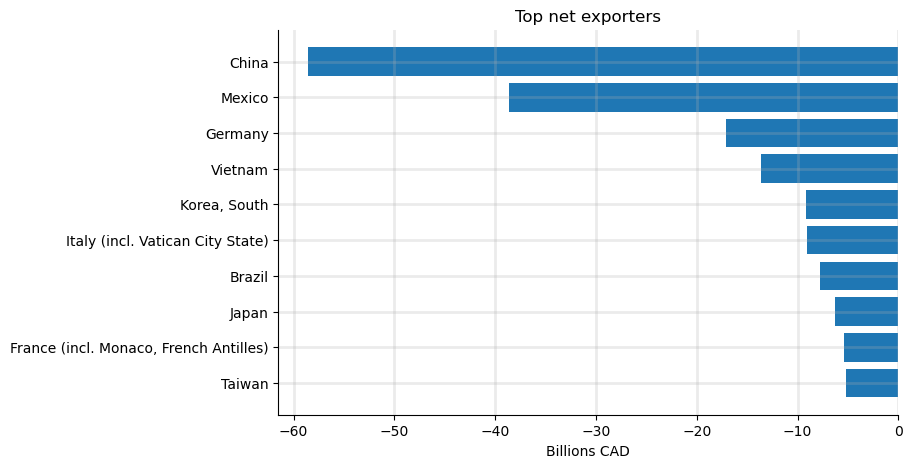

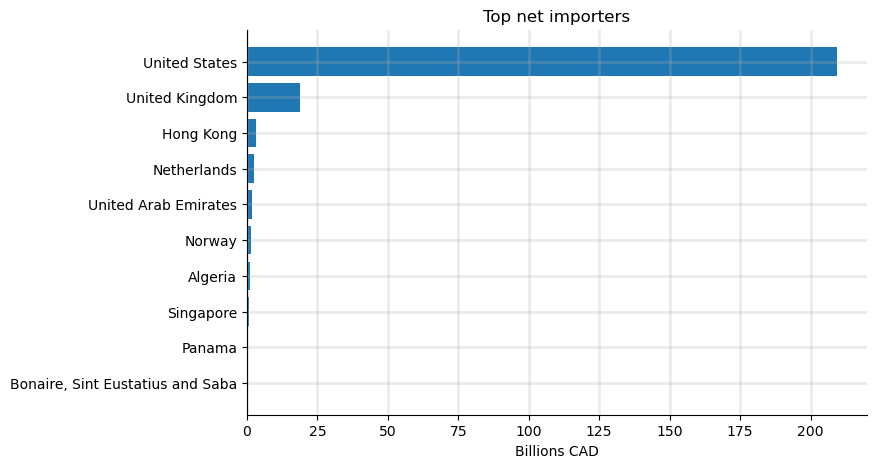

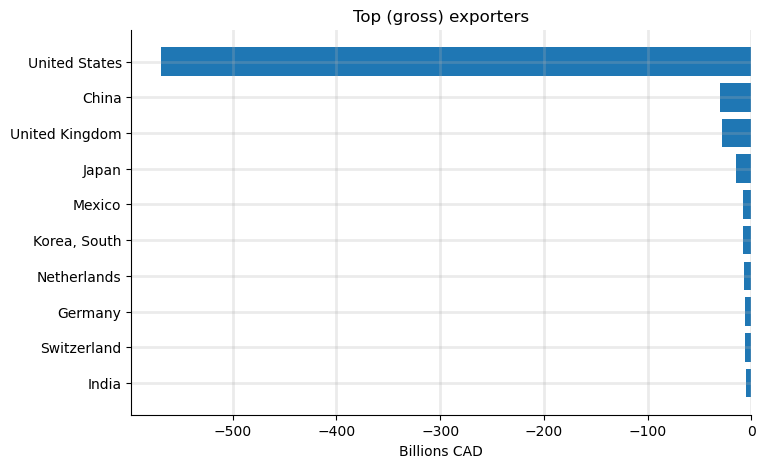

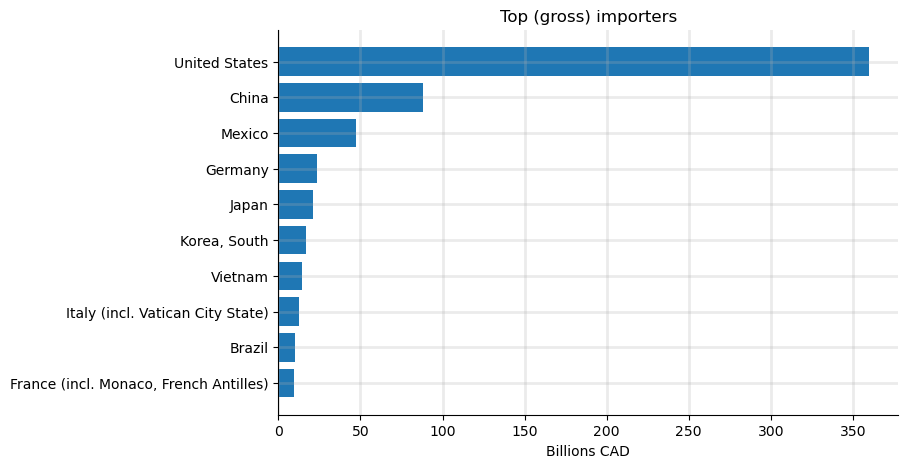

In [28]:
# trade in latest year
cond = cous['year'] == 2024
df = cous[cond]

data_dict = {}

# top net exporters
title, col = 'Top net exporters', 'tradebalance'
df = df.sort_values(col)
data_dict[title] = {'data' : df, 'col' : col}

# top net importers
title, col = 'Top net importers', 'tradebalance'
df = df.sort_values(col, ascending=False)
data_dict[title] = {'data' : df, 'col' : col}

# top gross exporters
title, col = 'Top (gross) exporters', 'exports'
df = df.sort_values(col)
data_dict[title] = {'data' : df, 'col' : col}

# top importers
title, col = 'Top (gross) importers', 'imports'
df = df.sort_values(col, ascending=False)
data_dict[title] = {'data' : df, 'col' : col}


for title, item in data_dict.items():
    
    data = item['data']
    col = item['col']

    top = 10
    data = data.head(top).reset_index(drop=True)
    data = data.reset_index()
    data.index += 1

    x, y = data['cou'], data[col] / B

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.barh(x, y)

    ax.set_title(title)
    ax.set_xlabel('Billions CAD')

    plt.gca().invert_yaxis()
    plt.show()

#### Top net exporters
|    |   year | cou                                    |      exports |     imports |   tradebalance |
|---:|-------:|:---------------------------------------|-------------:|------------:|---------------:|
|  0 |   2024 | China                                  | -2.98089e+10 | 8.83972e+10 |   -5.85883e+10 |
|  1 |   2024 | Mexico                                 | -8.46267e+09 | 4.70791e+10 |   -3.86164e+10 |
|  2 |   2024 | Germany                                | -6.29085e+09 | 2.33461e+10 |   -1.70553e+10 |
|  3 |   2024 | Vietnam                                | -1.00483e+09 | 1.46301e+10 |   -1.36252e+10 |
|  4 |   2024 | Korea, South                           | -7.56701e+09 | 1.67714e+10 |   -9.20443e+09 |
|  5 |   2024 | Italy (incl. Vatican City State)       | -3.26083e+09 | 1.23544e+10 |   -9.0936e+09  |
|  6 |   2024 | Brazil                                 | -2.42137e+09 | 1.01963e+10 |   -7.77494e+09 |
|  7 |   2024 | Japan                                  | -1.48197e+10 | 2.1118e+10  |   -6.29831e+09 |
|  8 |   2024 | France (incl. Monaco, French Antilles) | -4.30449e+09 | 9.71209e+09 |   -5.4076e+09  |
|  9 |   2024 | Re-Imports (Canada)                    | -0           | 5.35911e+09 |   -5.35911e+09 |
#### Top net importers
|    |   year | cou                              |      exports |       imports |   tradebalance |
|---:|-------:|:---------------------------------|-------------:|--------------:|---------------:|
|  0 |   2024 | Bonaire, Sint Eustatius and Saba | -3.84276e+08 | 543           |    3.84275e+08 |
|  1 |   2024 | Panama                           | -5.04711e+08 |   1.45576e+07 |    4.90153e+08 |
|  2 |   2024 | Singapore                        | -2.16104e+09 |   1.41878e+09 |    7.42267e+08 |
|  3 |   2024 | Algeria                          | -1.35964e+09 |   2.05541e+08 |    1.1541e+09  |
|  4 |   2024 | Norway                           | -2.2606e+09  |   8.8638e+08  |    1.37422e+09 |
|  5 |   2024 | United Arab Emirates             | -2.50839e+09 |   7.7645e+08  |    1.73194e+09 |
|  6 |   2024 | Netherlands                      | -7.04722e+09 |   4.56562e+09 |    2.4816e+09  |
|  7 |   2024 | Hong Kong                        | -3.57329e+09 |   2.69276e+08 |    3.30401e+09 |
|  8 |   2024 | United Kingdom                   | -2.81427e+10 |   9.16086e+09 |    1.89818e+10 |
|  9 |   2024 | United States                    | -5.69252e+11 |   3.59703e+11 |    2.09549e+11 |
#### Top (gross) exporters
|    |   year | cou                              |      exports |       imports |   tradebalance |
|---:|-------:|:---------------------------------|-------------:|--------------:|---------------:|
|  0 |   2024 | Bonaire, Sint Eustatius and Saba | -3.84276e+08 | 543           |    3.84275e+08 |
|  1 |   2024 | Panama                           | -5.04711e+08 |   1.45576e+07 |    4.90153e+08 |
|  2 |   2024 | Singapore                        | -2.16104e+09 |   1.41878e+09 |    7.42267e+08 |
|  3 |   2024 | Algeria                          | -1.35964e+09 |   2.05541e+08 |    1.1541e+09  |
|  4 |   2024 | Norway                           | -2.2606e+09  |   8.8638e+08  |    1.37422e+09 |
|  5 |   2024 | United Arab Emirates             | -2.50839e+09 |   7.7645e+08  |    1.73194e+09 |
|  6 |   2024 | Netherlands                      | -7.04722e+09 |   4.56562e+09 |    2.4816e+09  |
|  7 |   2024 | Hong Kong                        | -3.57329e+09 |   2.69276e+08 |    3.30401e+09 |
|  8 |   2024 | United Kingdom                   | -2.81427e+10 |   9.16086e+09 |    1.89818e+10 |
|  9 |   2024 | United States                    | -5.69252e+11 |   3.59703e+11 |    2.09549e+11 |
#### Top (gross) importers
|    |   year | cou                              |      exports |       imports |   tradebalance |
|---:|-------:|:---------------------------------|-------------:|--------------:|---------------:|
|  0 |   2024 | Bonaire, Sint Eustatius and Saba | -3.84276e+08 | 543           |    3.84275e+08 |
|  1 |   2024 | Panama                           | -5.04711e+08 |   1.45576e+07 |    4.90153e+08 |
|  2 |   2024 | Singapore                        | -2.16104e+09 |   1.41878e+09 |    7.42267e+08 |
|  3 |   2024 | Algeria                          | -1.35964e+09 |   2.05541e+08 |    1.1541e+09  |
|  4 |   2024 | Norway                           | -2.2606e+09  |   8.8638e+08  |    1.37422e+09 |
|  5 |   2024 | United Arab Emirates             | -2.50839e+09 |   7.7645e+08  |    1.73194e+09 |
|  6 |   2024 | Netherlands                      | -7.04722e+09 |   4.56562e+09 |    2.4816e+09  |
|  7 |   2024 | Hong Kong                        | -3.57329e+09 |   2.69276e+08 |    3.30401e+09 |
|  8 |   2024 | United Kingdom                   | -2.81427e+10 |   9.16086e+09 |    1.89818e+10 |
|  9 |   2024 | United States                    | -5.69252e+11 |   3.59703e+11 |    2.09549e+11 |


## Our main trade partners through time

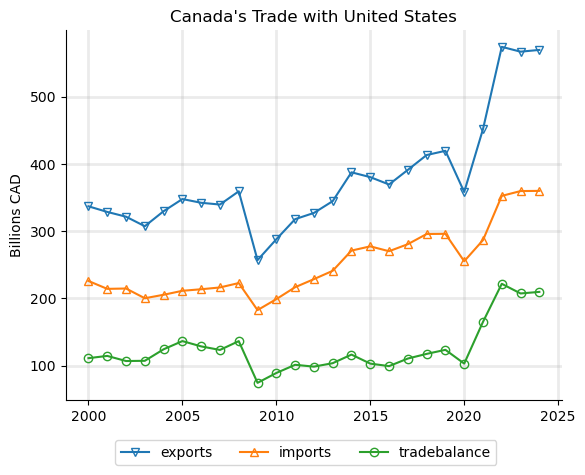

In [8]:
fig, ax = plt.subplots()


cond = cous['cou'] == 'United States'
us = cous[cond]

cols = ['exports', 'imports', 'tradebalance']
markers = ['v', '^', 'o']
for col, marker in zip(cols, markers):
    
    x, y = us['year'], us[col] / B
    
    ax.plot(x, y, marker=marker, fillstyle='none', label=col)

ax.set_title('Canada\'s Trade with United States')
ax.set_ylabel('Billions CAD')

fig.legend(loc='center', bbox_to_anchor=(0.5, 0), ncol=3)

plt.show()

## What do we trade?

In [9]:
# Canada's trade by sector/product

## Top trade partners by sector

In [10]:
# Breakdown trade by sector with top trader